In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Traget Distribution

In [26]:
class Distribution:    
    def calc_prob(self, z):
        p = np.zeros(z.shape[0])
        return p
    

    def plot(self, size=5):
        side = np.linspace(-size, size, 1000)
        z1, z2 = np.meshgrid(side, side)
        shape = z1.shape
        z1 = z1.ravel()
        z2 = z2.ravel()
        z = np.c_[z1, z2]
        probability = self.calc_prob(z).reshape(shape)
        plt.figure(figsize=(6, 6))
        plt.imshow(probability)
        plt.tick_params(bottom=False,left=False,right=False,top=False)
        plt.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
        plt.show()

In [27]:
class NormalDistribution2D(Distribution):
    def sample(self, sample_num):
        z = np.random.randn(sample_num, 2)
        return z
    

    def sample_tf(self, sample_num):
        z = tf.random_normal([sample_num, 2])
        return z
    

    def calc_prob(self, z):
        p = np.exp(-(z[:, 0]**2+z[:, 1]**2)/2)/(2*np.pi) 
        return p
    

    def calc_prob_torch(self, z):
        p = torch.exp(-(z[:, 0]**2+z[:, 1]**2)/2)/(2*np.pi) 
        return p

In [32]:
class TargetDistribution1(Distribution):
    def calc_prob(self, z):
        z1, z2 = z[:, 0], z[:, 1]
        norm = np.sqrt(z1**2+z2**2)
        exp1 = np.exp(-0.5*((z1-2)/0.6)**2)
        exp2 = np.exp(-0.5*((z1+2)/0.6)**2)
        p = 0.5*((norm - 2)/0.4)**2 - np.log(exp1 + exp2)
        return np.exp(-p)
    

    def calc_prob_torch(self, z):
        z1, z2 = z[:, 0], z[:, 1]
        norm = torch.sqrt(z1**2+z2**2)
        exp1 = torch.exp(-0.5*((z1-2)/0.6)**2)
        exp2 = torch.exp(-0.5*((z1+2)/0.6)**2)
        p = 0.5*((norm - 2)/0.4)**2 - torch.log(exp1 + exp2)
        return torch.exp(-p)

              0    1
0      -5.00000 -5.0
1      -4.98999 -5.0
2      -4.97998 -5.0
3      -4.96997 -5.0
4      -4.95996 -5.0
...         ...  ...
999995  4.95996  5.0
999996  4.96997  5.0
999997  4.97998  5.0
999998  4.98999  5.0
999999  5.00000  5.0

[1000000 rows x 2 columns]


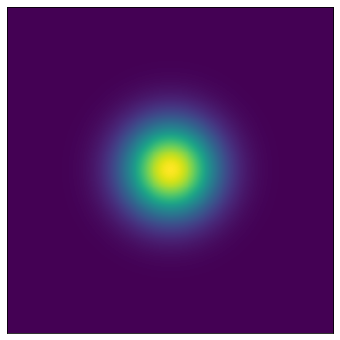

In [30]:
dist = NormalDistribution2D()
dist.plot()

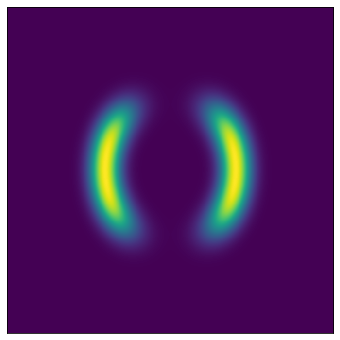

In [16]:
dist1 = TargetDistribution1()
dist1.plot()

# Define Model Architecture

When we stuck the same layer, we use nn.Modulelist.

**なぜロス関数の計算がああなる？？**


In [110]:
torch.zeros(1).normal_(0, 0.01)

tensor([0.0052])

In [239]:
class PlanarFlow(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.n_features = dim  # dimension of data
        self.h = lambda x: torch.tanh(x)
        self.h_prime = lambda x: 1 - torch.tanh(x) ** 2

        self.init_sigma = 0.01
        self.weights = nn.Parameter(torch.randn(1, dim).normal_(0, self.init_sigma))
        self.u = nn.Parameter(torch.randn(1, dim).normal_(0, self.init_sigma))
        self.bias = nn.Parameter(torch.zeros(1).normal_(0, self.init_sigma))
    

    def forward(self, x):
        
        if isinstance(x, tuple):
            z, logdet_jacobian = x
        else:
            z, logdet_jacobian = x, 0
        
        # Modification of u to have inverse transformation w^T * u >= -1      
        inner_wu = (self.weights @ self.u.t()).squeeze()
        u_hat = self.u + ( (-1 + torch.log1p(inner_wu.exp())) - inner_wu) * (self.weights / (self.weights @ self.weights.t()))

        z = z + u_hat * self.h( z @ self.weights.t() + self.bias )
        psi = self.h_prime (z @ self.weights.t() + self.bias) * self.weights
        det_jacob = torch.abs(1 + u_hat @ psi.t())
        logdet_jacobian += torch.log(det_jacob + 1e-7).squeeze()
        
        return z, logdet_jacobian

In [240]:
class NormalizingFlow(nn.Module):
    
    def __init__(self, dim, K):
        
        super(NormalizingFlow, self).__init__()
        
        self.dim = dim
        self.K = K
        self.flows = torch.nn.ModuleList()
        for k in range(K):
            self.flows.append(PlanarFlow(dim))
        
    def forward(self, z):
        # Flow calculation
        for flow in self.flows:
            z, log_q = flow(z)
            
        return z, log_q        

In [241]:
nflow = NormalizingFlow(dim=2, K=16)

# Loss Function

In [250]:
def calc_loss(z_k, log_q_k, target_density):
    log_p = torch.log(target_density.calc_prob_torch(z_k)+1e-7) # I need to understand this part
    loss = torch.mean(log_q_k - log_p, -1)
    return loss

# Training

In [251]:
import torch.optim as optim
from torch.distributions import multivariate_normal

optimizer = optim.Adam(nflow.parameters(), lr=0.01)

In [252]:
#  Distribution of the latent variable
standard_normal_2d = multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))

In [253]:
traget_density = TargetDistribution1()

In [254]:
def train_flow(flow, 
    lr_decay = 0.999,
    log_interval = 2000,
    iterations = 20000,
    batch_size = 100, ):

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)

    # anneal rate for free energy
    # temp = lambda i: min(1, 0.01 + i/10000)
    
    running_loss = 0
    for i in range(1, iterations + 1):

        scheduler.step()

        # Sample z_0
        samples = Variable(standard_normal_2d.sample(torch.Size([batch_size])))
        
        z_k, log_q_k = flow(samples)
        optimizer.zero_grad()
        loss = calc_loss(z_k, log_q_k, target_density=traget_density)
        loss.backward()
        optimizer.step()

        # print learing process
        running_loss += loss.item()
        if i % log_interval == 0:
            print('[%5d] loss: %.3f' %
                  (i, running_loss / log_interval))
            running_loss = 0.0

In [255]:
train_flow(nflow)

[ 2000] loss: -13.587
[ 4000] loss: -14.035
[ 6000] loss: -14.056
[ 8000] loss: -14.064
[10000] loss: -14.071
[12000] loss: -15.979
[14000] loss: -15.979
[16000] loss: -15.979
[18000] loss: -15.979
[20000] loss: -15.979


# Check the results

In [256]:
x, y = np.meshgrid(np.linspace(-7,7,100), np.linspace(-7,7,100))
z0 = torch.tensor(np.dstack((x,y)).reshape(-1, 2), dtype=torch.float32)
zk = nflow( z0 )[0].data.numpy()

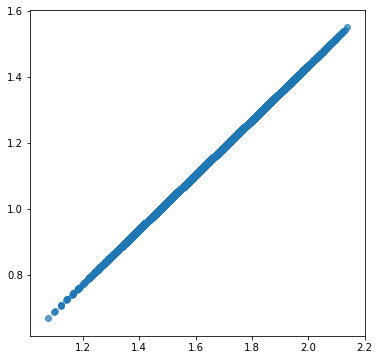

In [257]:
plt.figure(figsize=(6, 6))
plt.scatter(zk[:, 0], zk[:, 1], alpha=0.7)
plt.show()